In [340]:
import pandas as pd
import ast
import numpy as np

import cv2
import numpy as np
import pandas as pd
from IPython.display import Image

import json

In [341]:
def convert_str_to_list(coord_str):
    return ast.literal_eval(coord_str)

train_barlines = pd.read_csv('deepscores_train_barlines.csv')


# train_barlines = train_barlines[train_barlines['label']==156]

# train_barlines['a_bbox'] = train_barlines['a_bbox'].apply(convert_str_to_list)
# train_barlines['o_bbox'] = train_barlines['o_bbox'].apply(convert_str_to_list)

train_barlines['a_bbox'] = train_barlines['a_bbox'].apply(json.loads)
train_barlines['o_bbox'] = train_barlines['o_bbox'].apply(json.loads)

# Sort by 'filename' first, then by y-coordinate, then by x-coordinate
train_barlines = train_barlines.iloc[np.lexsort((train_barlines['o_bbox'].apply(lambda x: x[0]),
                                                 train_barlines['o_bbox'].apply(lambda x: x[1]),
                                                 train_barlines['filename']))]

# Getting the line number and measure numbers for barlines

In [342]:
# Function to detect if bboxes are on the same line
def on_same_line(bbox1, bbox2):
    # Extract the y-coordinates of the top left corner of the bounding boxes
    y1_top_left = bbox1[1]
    y2_top_left = bbox2[1]
    
    # Check if the y-coordinates are within a 1-2 pixel range
    return abs(y1_top_left - y2_top_left) <= 2

def check_and_assign_measure(group, current_index, measure_num):
    # Check for adjacent line measures and assign the same measure number
    for j in range(current_index + 1, len(group)):
        if group.iat[j, group.columns.get_loc('measure_number')] == -1:
            if abs(group.iat[current_index, group.columns.get_loc('x_coord')] - group.iat[j, group.columns.get_loc('x_coord')]) <= 2 and \
               abs(group.iat[current_index, group.columns.get_loc('line_number')] - group.iat[j, group.columns.get_loc('line_number')]) == 1:
                group.iat[j, group.columns.get_loc('measure_number')] = measure_num
                # Recursively check the next line
                check_and_assign_measure(group, j, measure_num)

def find_second_max(group):
    # Sort the values in descending order and drop duplicates to ensure unique values
    unique_sorted = group.drop_duplicates().sort_values(ascending=False)
    # Return the second maximum if it exists, otherwise return the maximum
    return unique_sorted.iloc[1] if len(unique_sorted) > 1 else unique_sorted.iloc[0]


# Function to numerically encode the bar lines based on their y-coordinates
def process_group(group, filename):
    
    # Sort by y-coordinate first to group by line, then by x-coordinate to maintain left-to-right order
    # Assuming 'o_bbox' is a list with the structure [x1, y1, x2, y2, x3, y3, x4, y4]
    # where (x1, y1) are the coordinates for the top-left corner of the bbox
    group = group.sort_values(by=['o_bbox']).reset_index(drop=True)
    
    # Split the 'o_bbox' column into separate x and y columns for sorting
    group['x_coord'] = group['o_bbox'].apply(lambda x: x[0])  # x1 coordinate
    group['y_coord'] = group['o_bbox'].apply(lambda x: x[1])  # y1 coordinate
    group = group.sort_values(by=['y_coord', 'x_coord']).reset_index(drop=True)

    # Initialize line number
    line_number = 0
    group['line_number'] = line_number  # Initialize line number column
    
    # Iterate through each bbox
    for i in range(1, len(group)):
        # If the y-coordinates change significantly, it's a new line
        if not on_same_line(group.iloc[i-1]['o_bbox'], group.iloc[i]['o_bbox']):
            line_number += 1
            # probably error
            if line_number == 100:
                print(f"Line number exceeded 100 for {filename}")
        # Assign the current line number
        group.iat[i, group.columns.get_loc('line_number')] = line_number

    # Normalize the y-coordinates within each line
    for line in group['line_number'].unique():
        mean_y = group[group['line_number'] == line]['y_coord'].mean()
        group.loc[group['line_number'] == line, 'y_coord'] = mean_y

    # # Identify and remove redundant barlines
    max_x_per_line = group.groupby('line_number')['x_coord'].max()
    group = group[group.apply(lambda row: row['x_coord'] < max_x_per_line[row['line_number']], axis=1)] 

    # Identify and remove redundant barlines using second max if necessary
    # max_x_per_line = group.groupby('line_number')['x_coord'].apply(lambda x: x.nlargest(2).iloc[-1] if len(x) > 1 else None)
    # group = group[group.apply(lambda row: row['x_coord'] < max_x_per_line[row['line_number']] if max_x_per_line[row['line_number']] is not None else True, axis=1)]

    # second_max_per_line = (group.groupby('line_number')['x_coord'].apply(find_second_max))
    # group = group[group.apply(lambda row: row['x_coord'] < second_max_per_line[row['line_number']], axis=1)] #### add this later to omit the last barlines at each line

    # Initialize measure numbers
    group['measure_number'] = -1  # Initialize with -1 to denote unassigned measures
    measure_number = 0

    group = group.sort_values(by=['y_coord', 'x_coord'], ascending=[True, False]).reset_index(drop=True)

    # Assign measure numbers by comparing each bbox to every other bbox
    for i in range(len(group)):
        if group.iat[i, group.columns.get_loc('measure_number')] == -1:
            group.iat[i, group.columns.get_loc('measure_number')] = measure_number
            check_and_assign_measure(group, i, measure_number)
            measure_number += 1  # Increment measure number after fully exploring all consecutive lines

        if measure_number == 200:
            print(f"Measure number exceeded 200 for {filename}")  # Error handling if too many measures

    # Drop the helper columns after processing
    group.drop(['x_coord', 'y_coord'], axis=1, inplace=True)
    
    return group


# Group by 'filename' and apply the process_group function with sorting

# # The rest of your code remains the same.
# image_path = 'lg-102414375-aug-beethoven--page-2.png'
# train_barlines = train_barlines[train_barlines["filename"]==image_path]

train_barlines = train_barlines.groupby('filename', group_keys=False).apply(lambda x: process_group(x, x.name), include_groups=True).reset_index(drop=True)

train_barlines = train_barlines.sort_values(by=['filename', 'line_number', 'measure_number'])

train_barlines.head(20)

/var/folders/g8/btdyhprd6l7_z7kmyr6qhzp80000gn/T/ipykernel_20357/378484737.py:99: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  train_barlines = train_barlines.groupby('filename', group_keys=False).apply(lambda x: process_group(x, x.name), include_groups=True).reset_index(drop=True)


,filename,a_bbox,o_bbox,padded_a_bbox,padded_o_bbox,area,width,height,ann_id,label,duration,rel_position,duration_mask,rel_position_mask,line_number,measure_number
0,lg-101766503886095953-aug-beethoven--page-1.png,"[1387.0, 377.0, 1390.0, 443.0]","[1387.0, 377.0, 1387.0, 443.0, 1390.0, 443.0, ...","[1387.0, 377.0, 1390.0, 443.0]","[1387.0, 377.0, 1387.0, 443.0, 1390.0, 443.0, ...",198.0,-1,-1,-5157,156,-1,0,0,0,0,0
1,lg-101766503886095953-aug-beethoven--page-1.png,"[910.0, 377.0, 913.0, 443.0]","[910.0, 377.0, 910.0, 443.0, 913.0, 443.0, 913...","[910.0, 377.0, 913.0, 443.0]","[910.0, 377.0, 910.0, 443.0, 913.0, 443.0, 913...",198.0,-1,-1,-5158,156,-1,0,0,0,0,1
2,lg-101766503886095953-aug-beethoven--page-1.png,"[1387.0, 606.0, 1390.0, 671.0]","[1387.0, 606.0, 1387.0, 671.0, 1390.0, 671.0, ...","[1387.0, 606.0, 1390.0, 671.0]","[1387.0, 606.0, 1387.0, 671.0, 1390.0, 671.0, ...",195.0,-1,-1,-5153,156,-1,0,0,0,1,0
3,lg-101766503886095953-aug-beethoven--page-1.png,"[910.0, 606.0, 913.0, 671.0]","[910.0, 606.0, 910.0, 671.0, 913.0, 671.0, 913...","[910.0, 606.0, 913.0, 671.0]","[910.0, 606.0, 910.0, 671.0, 913.0, 671.0, 913...",195.0,-1,-1,-5154,156,-1,0,0,0,1,1
4,lg-101766503886095953-aug-beethoven--page-1.png,"[1387.0, 834.0, 1390.0, 899.0]","[1387.0, 834.0, 1387.0, 899.0, 1390.0, 899.0, ...","[1387.0, 834.0, 1390.0, 899.0]","[1387.0, 834.0, 1387.0, 899.0, 1390.0, 899.0, ...",195.0,-1,-1,-5150,156,-1,0,0,0,2,0
5,lg-101766503886095953-aug-beethoven--page-1.png,"[910.0, 833.0, 913.0, 900.0]","[910.0, 833.0, 910.0, 900.0, 913.0, 900.0, 913...","[910.0, 833.0, 913.0, 900.0]","[910.0, 833.0, 910.0, 900.0, 913.0, 900.0, 913...",201.0,-1,-1,-5152,156,-1,0,0,0,2,1
6,lg-101766503886095953-aug-beethoven--page-1.png,"[1387.0, 1027.0, 1390.0, 1092.0]","[1387.0, 1027.0, 1387.0, 1092.0, 1390.0, 1092....","[1387.0, 1027.0, 1390.0, 1092.0]","[1387.0, 1027.0, 1387.0, 1092.0, 1390.0, 1092....",195.0,-1,-1,-5147,156,-1,0,0,0,3,0
7,lg-101766503886095953-aug-beethoven--page-1.png,"[910.0, 1027.0, 913.0, 1092.0]","[910.0, 1027.0, 910.0, 1092.0, 913.0, 1092.0, ...","[910.0, 1027.0, 913.0, 1092.0]","[910.0, 1027.0, 910.0, 1092.0, 913.0, 1092.0, ...",195.0,-1,-1,-5148,156,-1,0,0,0,3,1
8,lg-101766503886095953-aug-beethoven--page-1.png,"[1465.0, 1754.0, 1468.0, 1819.0]","[1465.0, 1754.0, 1465.0, 1819.0, 1468.0, 1819....","[1465.0, 1754.0, 1468.0, 1819.0]","[1465.0, 1754.0, 1465.0, 1819.0, 1468.0, 1819....",195.0,-1,-1,-5143,156,-1,0,0,0,4,2
9,lg-101766503886095953-aug-beethoven--page-1.png,"[1064.0, 1754.0, 1067.0, 1820.0]","[1064.0, 1754.0, 1064.0, 1820.0, 1067.0, 1820....","[1064.0, 1754.0, 1067.0, 1820.0]","[1064.0, 1754.0, 1064.0, 1820.0, 1067.0, 1820....",198.0,-1,-1,-5146,156,-1,0,0,0,4,3


# Creating measures using barlines

In [343]:
def group_measures_by_line(group):

    # Assuming the width and height are constant within each group (filename)
    width = group['width'].iloc[0]
    height = group['height'].iloc[0]
    
    # Sort the group by line number and measure number
    sorted_group = group.sort_values(by=['line_number', 'measure_number'])
    measure_memo = set()
    # Dictionary to hold the bounding boxes grouped by line and measure
    bbox_groups = {}
    special_measure_count = 1  # Counter for special measures

    # Iterate over each line
    for line_number in sorted_group['line_number'].unique():
        line_data = sorted_group[sorted_group['line_number'] == line_number].copy()

        # Check if there is only one row in this line
        if len(line_data) == 1:

            current_measure = line_data['measure_number'].values[0]

            if current_measure in measure_memo:
                continue
            else:
                measure_memo.add(current_measure)

            measure_key_initial = f"initial_special_measure_{special_measure_count}"
            
            measure_key_final = f"final_special_measure_{special_measure_count}"

            # Initialize measure key if not present
            if measure_key_initial not in bbox_groups:
                bbox_groups[measure_key_initial] = []

            # Initialize measure key if not present
            if measure_key_final not in bbox_groups:
                bbox_groups[measure_key_final] = []
            
            # Original bbox
            bbox_groups[measure_key_initial].append(line_data['o_bbox'].values[0].copy())

            # Original bbox
            bbox_groups[measure_key_final].append(line_data['o_bbox'].values[0].copy())


            # Append all bounding boxes for the same measure
            for coords in group[group['measure_number']==current_measure]['o_bbox'].values:
                bbox_groups[measure_key_initial].append(coords)
                bbox_groups[measure_key_final].append(coords)

            # Modified bbox with certain indices set to 0
            modified_bbox_initial = line_data['o_bbox'].values[0].copy()
            for index in [0]:
                modified_bbox_initial[index] = 0  # Set specified indices to 0
            bbox_groups[measure_key_initial].append(modified_bbox_initial)

            # Modified bbox with certain indices set to 1960
            modified_bbox_final = line_data['o_bbox'].values[0].copy()
            for index in [0]:
                modified_bbox_final[index] = 1960  # Set specified indices to 1960
            bbox_groups[measure_key_final].append(modified_bbox_final)

            special_measure_count += 1

        else:
            # Iterate through the measures in the line normally
            for i in range(len(line_data) - 1):  # -1 because we look ahead one measure
                current_measure = line_data.iloc[i]
                next_measure = line_data.iloc[i + 1]

                # Check if the next measure number is consecutive
                if current_measure['measure_number'] + 1 == next_measure['measure_number']:
                    # Create the key as 'measure_current_current+1'
                    key = f"measure_{current_measure['measure_number']}_{next_measure['measure_number']}"
                    
                    # If the key doesn't exist, create it and assign an empty list
                    if key not in bbox_groups:
                        bbox_groups[key] = []

                    # Append the current and next bounding boxes to the list under the key
                    bbox_groups[key].append(current_measure['o_bbox'])
                    bbox_groups[key].append(next_measure['o_bbox'])

    return bbox_groups

# Now, group by 'filename' and apply the grouping function
grouped_bbox_data = train_barlines.groupby("filename").apply(group_measures_by_line, include_groups=False)

# Now, group by 'filename' and apply the grouping function
grouped_bbox_df = pd.DataFrame(grouped_bbox_data).reset_index()

- adding width/height information

In [344]:
# Load JSON data into a dictionary
with open('./deepscores_train.json') as file:
    data1 = json.load(file)

train_images = pd.DataFrame( data1['images'])

# Update the width and height of the images
filename_to_dimensions = dict(zip(train_images['filename'], zip(train_images['width'], train_images['height'])))

# Use map to update 'width' and 'height' columns in measures_df based on filename
grouped_bbox_df['width'] = grouped_bbox_df['filename'].map(lambda x: filename_to_dimensions.get(x, (np.nan, np.nan))[0])
grouped_bbox_df['height'] = grouped_bbox_df['filename'].map(lambda x: filename_to_dimensions.get(x, (np.nan, np.nan))[1])

grouped_bbox_df.head(10)

,filename,0,width,height
0,lg-101766503886095953-aug-beethoven--page-1.png,"{'measure_0_1': [[1387.0, 377.0, 1387.0, 443.0...",1960,2772
1,lg-101766503886095953-aug-beethoven--page-4.png,"{'measure_0_1': [[1456.0, 128.0, 1456.0, 193.0...",1960,2772
2,lg-101766503886095953-aug-gonville--page-1.png,"{'measure_0_1': [[1381.0, 377.0, 1381.0, 443.0...",1960,2772
3,lg-101766503886095953-aug-gonville--page-4.png,"{'measure_0_1': [[1453.0, 128.0, 1453.0, 193.0...",1960,2772
4,lg-102414375-aug-beethoven--page-2.png,"{'measure_0_1': [[1435.0, 128.0, 1435.0, 194.0...",1960,2772
5,lg-102414375-aug-gutenberg1939--page-3.png,"{'measure_0_1': [[1560.0, 139.0, 1560.0, 206.0...",1960,2772
6,lg-10247684-aug-beethoven--page-2.png,"{'initial_special_measure_1': [[1061.0, 146.0,...",1960,2772
7,lg-10247684-aug-beethoven--page-3.png,"{'measure_0_1': [[1305.0, 173.0, 1305.0, 240.0...",1960,2772
8,lg-10247684-aug-gonville--page-2.png,"{'initial_special_measure_1': [[1058.0, 146.0,...",1960,2772
9,lg-10247684-aug-gonville--page-3.png,"{'measure_0_1': [[1301.0, 173.0, 1301.0, 240.0...",1960,2772


# Calculating the vertices for each measure

In [345]:
grouped_bbox_df.columns

Index(['filename', 0, 'width', 'height'], dtype='object')

In [346]:
# Function to process each dictionary and extract min/max coordinates
def calc_coordinates(bbox_dict):
    result = {}
    for key, bboxes in bbox_dict.items():
        min_x = min(min(bbox[0], bbox[2], bbox[4], bbox[6]) for bbox in bboxes)
        min_y = min(min(bbox[1], bbox[3], bbox[5], bbox[7]) for bbox in bboxes)
        max_x = max(max(bbox[0], bbox[2], bbox[4], bbox[6]) for bbox in bboxes)
        max_y = max(max(bbox[1], bbox[3], bbox[5], bbox[7]) for bbox in bboxes)
        result[key] = [min_x, min_y, max_x, min_y, max_x, max_y, min_x, max_y]
    return result

# Apply the function to each row in the 'o_bbox' column
grouped_bbox_df['measure_bbox'] = grouped_bbox_df[0].apply(calc_coordinates)

grouped_bbox_df.head()

,filename,0,width,height,measure_bbox
0,lg-101766503886095953-aug-beethoven--page-1.png,"{'measure_0_1': [[1387.0, 377.0, 1387.0, 443.0...",1960,2772,"{'measure_0_1': [910.0, 377.0, 1390.0, 377.0, ..."
1,lg-101766503886095953-aug-beethoven--page-4.png,"{'measure_0_1': [[1456.0, 128.0, 1456.0, 193.0...",1960,2772,"{'measure_0_1': [1045.0, 128.0, 1459.0, 128.0,..."
2,lg-101766503886095953-aug-gonville--page-1.png,"{'measure_0_1': [[1381.0, 377.0, 1381.0, 443.0...",1960,2772,"{'measure_0_1': [897.0, 377.0, 1384.0, 377.0, ..."
3,lg-101766503886095953-aug-gonville--page-4.png,"{'measure_0_1': [[1453.0, 128.0, 1453.0, 193.0...",1960,2772,"{'measure_0_1': [1041.0, 128.0, 1457.0, 128.0,..."
4,lg-102414375-aug-beethoven--page-2.png,"{'measure_0_1': [[1435.0, 128.0, 1435.0, 194.0...",1960,2772,"{'measure_0_1': [1035.0, 128.0, 1438.0, 128.0,..."


- adding initial measures

In [347]:
def process_bboxes_initial(data, tolerance=2):
    # Group by min_y and max_y and find the minimum min_x for each group, within a tolerance
    grouped_data = {}
    new_bboxes = {}  # Use this to store new entries

    for key, box in data.items():
        if key.startswith('measure'):
            min_x, min_y, max_x, max_y = box[0], box[1], box[2], box[5]

            # Check if min_x is within the tolerance to continue processing
            if min_x < tolerance:
                continue  # Skip this entry if it doesn't meet criteria

            similar_y_key_found = False
            # Check each y_key in grouped_data to see if it's within the tolerance level
            for y_key in grouped_data.keys():
                if (abs(y_key[0] - min_y) <= tolerance) and (abs(y_key[1] - max_y) <= tolerance):
                    # If found, update the similar y_key with the min of min_x values
                    grouped_data[y_key] = min(grouped_data[y_key], min_x)
                    similar_y_key_found = True
                    break

            # If no similar y_key was found, add this box as a new entry
            if not similar_y_key_found:
                grouped_data[(min_y, max_y)] = min_x

    # Create new bounding boxes using the real min_x and the y_key values
    count = 0
    for y_key, real_min_x in grouped_data.items():
        if real_min_x == 0:
            continue  # Skip entries with real_min_x set to zero
        new_key = f"initial_measure_{count}"
        new_bboxes[new_key] = [0, y_key[0], real_min_x, y_key[0], real_min_x, y_key[1], 0, y_key[1]]
        count += 1

    # Update the original data dictionary with new entries
    data.update(new_bboxes)

    return data

# Assuming 'grouped_bbox_df' and 'measure_bbox' column exists and is properly formatted,
# Apply the function to the DataFrame
grouped_bbox_df['new_measure_bbox'] = grouped_bbox_df['measure_bbox'].apply(process_bboxes_initial)


- adding final measures

- old

In [348]:
# def process_bboxes_final(data, tolerance=2):
#     # Group by min_y and max_y and find the maximum min_x for each group, within a tolerance
#     grouped_data = {}
#     new_bboxes = {}  # Use this to store new entries to avoid modifying `data` during iteration

#     for key, box in data.items():
#         if key.startswith('measure'):
#             min_x, min_y, max_x, max_y = box[0], box[1], box[2], box[5]

#             # This will be used to check if we have a similar y_key already in grouped_data
#             similar_y_key_found = False

#             # Check each y_key in grouped_data to see if it's within the tolerance level
#             for y_key in grouped_data.keys():
#                 if (abs(y_key[0] - min_y) <= tolerance) and (abs(y_key[1] - max_y) <= tolerance):
#                     # If found, update the similar y_key with the max of max_x values
#                     grouped_data[y_key] = max(grouped_data[y_key], max_x)
#                     similar_y_key_found = True
#                     break

#             # If no similar y_key was found, add this box as a new entry
#             if not similar_y_key_found:
#                 grouped_data[(min_y, max_y)] = max_x

#     # Form the new bounding boxes using the real max_x and the y_key values
#     count = 0
#     for y_key, real_max_x in grouped_data.items():
#         new_key = f"final_measure_{count}"
#         new_bboxes[new_key] = [1960, y_key[0], real_max_x, y_key[0], real_max_x, y_key[1], 1960, y_key[1]]
#         count += 1

#     # Update the original data dictionary with new entries
#     data.update(new_bboxes)

#     return data

# # Assuming 'grouped_bbox_df' and 'measure_bbox' column exist and are properly formatted
# # Apply the function to the DataFrame
# # image_path = 'lg-10247684-aug-beethoven--page-2.png'
# # grouped_bbox_df = grouped_bbox_df[grouped_bbox_df['filename'] == image_path]
# grouped_bbox_df['new_measure_bbox_updated'] = grouped_bbox_df['new_measure_bbox'].apply(process_bboxes_final)


- new

In [349]:
def process_bboxes_final_new(row, tolerance=2):

    # Extract data from the row
    data = row['new_measure_bbox']
    width = row['width']
    height = row['height']

    # Group by min_y and max_y and find the maximum min_x for each group, within a tolerance
    grouped_data = {}
    new_bboxes = {}

    for key, box in data.items():
        if key.startswith('measure'):
            min_x, min_y, max_x, max_y = box[0], box[1], box[2], box[5]

            # This will be used to check if we have a similar y_key already in grouped_data
            similar_y_key_found = False

            # Check each y_key in grouped_data to see if it's within the tolerance level
            for y_key in grouped_data.keys():
                if (abs(y_key[0] - min_y) <= tolerance) and (abs(y_key[1] - max_y) <= tolerance):
                    # If found, update the similar y_key with the max of max_x values
                    grouped_data[y_key] = max(grouped_data[y_key], max_x)
                    similar_y_key_found = True
                    break

            # If no similar y_key was found, add this box as a new entry
            if not similar_y_key_found:
                grouped_data[(min_y, max_y)] = max_x

    # Form the new bounding boxes using the real max_x and the y_key values
    count = 0
    for y_key, real_max_x in grouped_data.items():
        new_key = f"final_measure_{count}"
        new_bboxes[new_key] = [width, y_key[0], real_max_x, y_key[0], real_max_x, y_key[1], width, y_key[1]]
        count += 1

    # Update the original data dictionary with new entries
    data.update(new_bboxes)

    return data

# Apply the function to the DataFrame assuming 'new_measure_bbox' is a dictionary stored in each row
grouped_bbox_df['new_measure_bbox_updated'] = grouped_bbox_df.apply(process_bboxes_final_new, axis=1)

In [350]:
grouped_bbox_df.drop([0, 'measure_bbox', 'new_measure_bbox' ], axis=1, inplace=True)

grouped_bbox_df.head(10)

,filename,width,height,new_measure_bbox_updated
0,lg-101766503886095953-aug-beethoven--page-1.png,1960,2772,"{'measure_0_1': [910.0, 377.0, 1390.0, 377.0, ..."
1,lg-101766503886095953-aug-beethoven--page-4.png,1960,2772,"{'measure_0_1': [1045.0, 128.0, 1459.0, 128.0,..."
2,lg-101766503886095953-aug-gonville--page-1.png,1960,2772,"{'measure_0_1': [897.0, 377.0, 1384.0, 377.0, ..."
3,lg-101766503886095953-aug-gonville--page-4.png,1960,2772,"{'measure_0_1': [1041.0, 128.0, 1457.0, 128.0,..."
4,lg-102414375-aug-beethoven--page-2.png,1960,2772,"{'measure_0_1': [1035.0, 128.0, 1438.0, 128.0,..."
5,lg-102414375-aug-gutenberg1939--page-3.png,1960,2772,"{'measure_0_1': [1331.0, 139.0, 1563.0, 139.0,..."
6,lg-10247684-aug-beethoven--page-2.png,1960,2772,"{'initial_special_measure_1': [0, 146.0, 1064...."
7,lg-10247684-aug-beethoven--page-3.png,1960,2772,"{'measure_0_1': [753.0, 173.0, 1308.0, 173.0, ..."
8,lg-10247684-aug-gonville--page-2.png,1960,2772,"{'initial_special_measure_1': [0, 146.0, 1061...."
9,lg-10247684-aug-gonville--page-3.png,1960,2772,"{'measure_0_1': [749.0, 173.0, 1304.0, 173.0, ..."


# **TEST**

In [351]:
# The rest of your code remains the same.
image_path = 'lg-91939111-aug-beethoven--page-1.png'

# 'lg-11466156-aug-gutenberg1939--page-3.png' --

# 'lg-102548668-aug-gutenberg1939--page-1.png'

# Filtering
test_df = train_barlines[train_barlines["filename"]==image_path]

test_df = test_df.sort_values(by=['line_number', 'measure_number'])

test_df = test_df.reset_index()

test_df.head(40)

,index,filename,a_bbox,o_bbox,padded_a_bbox,padded_o_bbox,area,width,height,ann_id,label,duration,rel_position,duration_mask,rel_position_mask,line_number,measure_number
0,45128,lg-91939111-aug-beethoven--page-1.png,"[1837.0, 222.0, 1840.0, 288.0]","[1837.0, 222.0, 1837.0, 288.0, 1840.0, 288.0, ...","[1837.0, 222.0, 1840.0, 288.0]","[1837.0, 222.0, 1837.0, 288.0, 1840.0, 288.0, ...",198.0,-1,-1,-12721,156,-1,0,0,0,0,0
1,45129,lg-91939111-aug-beethoven--page-1.png,"[1574.0, 223.0, 1578.0, 287.0]","[1574.0, 223.0, 1574.0, 287.0, 1578.0, 287.0, ...","[1574.0, 223.0, 1578.0, 287.0]","[1574.0, 223.0, 1574.0, 287.0, 1578.0, 287.0, ...",256.0,-1,-1,-12718,156,-1,0,0,0,0,1
2,45130,lg-91939111-aug-beethoven--page-1.png,"[1305.0, 222.0, 1308.0, 288.0]","[1305.0, 222.0, 1305.0, 288.0, 1308.0, 288.0, ...","[1305.0, 222.0, 1308.0, 288.0]","[1305.0, 222.0, 1305.0, 288.0, 1308.0, 288.0, ...",198.0,-1,-1,-12722,156,-1,0,0,0,0,2
3,45131,lg-91939111-aug-beethoven--page-1.png,"[1021.0, 222.0, 1025.0, 288.0]","[1021.0, 222.0, 1021.0, 288.0, 1025.0, 288.0, ...","[1021.0, 222.0, 1025.0, 288.0]","[1021.0, 222.0, 1021.0, 288.0, 1025.0, 288.0, ...",264.0,-1,-1,-12723,156,-1,0,0,0,0,3
4,45132,lg-91939111-aug-beethoven--page-1.png,"[759.0, 223.0, 762.0, 287.0]","[759.0, 223.0, 759.0, 287.0, 762.0, 287.0, 762...","[759.0, 223.0, 762.0, 287.0]","[759.0, 223.0, 759.0, 287.0, 762.0, 287.0, 762...",192.0,-1,-1,-12719,156,-1,0,0,0,0,4
5,45133,lg-91939111-aug-beethoven--page-1.png,"[490.0, 222.0, 493.0, 288.0]","[490.0, 222.0, 490.0, 288.0, 493.0, 288.0, 493...","[490.0, 222.0, 493.0, 288.0]","[490.0, 222.0, 490.0, 288.0, 493.0, 288.0, 493...",198.0,-1,-1,-12724,156,-1,0,0,0,0,5
6,45134,lg-91939111-aug-beethoven--page-1.png,"[1837.0, 394.0, 1840.0, 458.0]","[1837.0, 394.0, 1837.0, 458.0, 1840.0, 458.0, ...","[1837.0, 394.0, 1840.0, 458.0]","[1837.0, 394.0, 1837.0, 458.0, 1840.0, 458.0, ...",192.0,-1,-1,-12711,156,-1,0,0,0,1,0
7,45135,lg-91939111-aug-beethoven--page-1.png,"[1574.0, 394.0, 1578.0, 458.0]","[1574.0, 394.0, 1574.0, 458.0, 1578.0, 458.0, ...","[1574.0, 394.0, 1578.0, 458.0]","[1574.0, 394.0, 1574.0, 458.0, 1578.0, 458.0, ...",256.0,-1,-1,-12712,156,-1,0,0,0,1,1
8,45136,lg-91939111-aug-beethoven--page-1.png,"[1305.0, 394.0, 1308.0, 458.0]","[1305.0, 394.0, 1305.0, 458.0, 1308.0, 458.0, ...","[1305.0, 394.0, 1308.0, 458.0]","[1305.0, 394.0, 1305.0, 458.0, 1308.0, 458.0, ...",192.0,-1,-1,-12713,156,-1,0,0,0,1,2
9,45137,lg-91939111-aug-beethoven--page-1.png,"[1021.0, 394.0, 1025.0, 458.0]","[1021.0, 394.0, 1021.0, 458.0, 1025.0, 458.0, ...","[1021.0, 394.0, 1025.0, 458.0]","[1021.0, 394.0, 1021.0, 458.0, 1025.0, 458.0, ...",256.0,-1,-1,-12714,156,-1,0,0,0,1,3


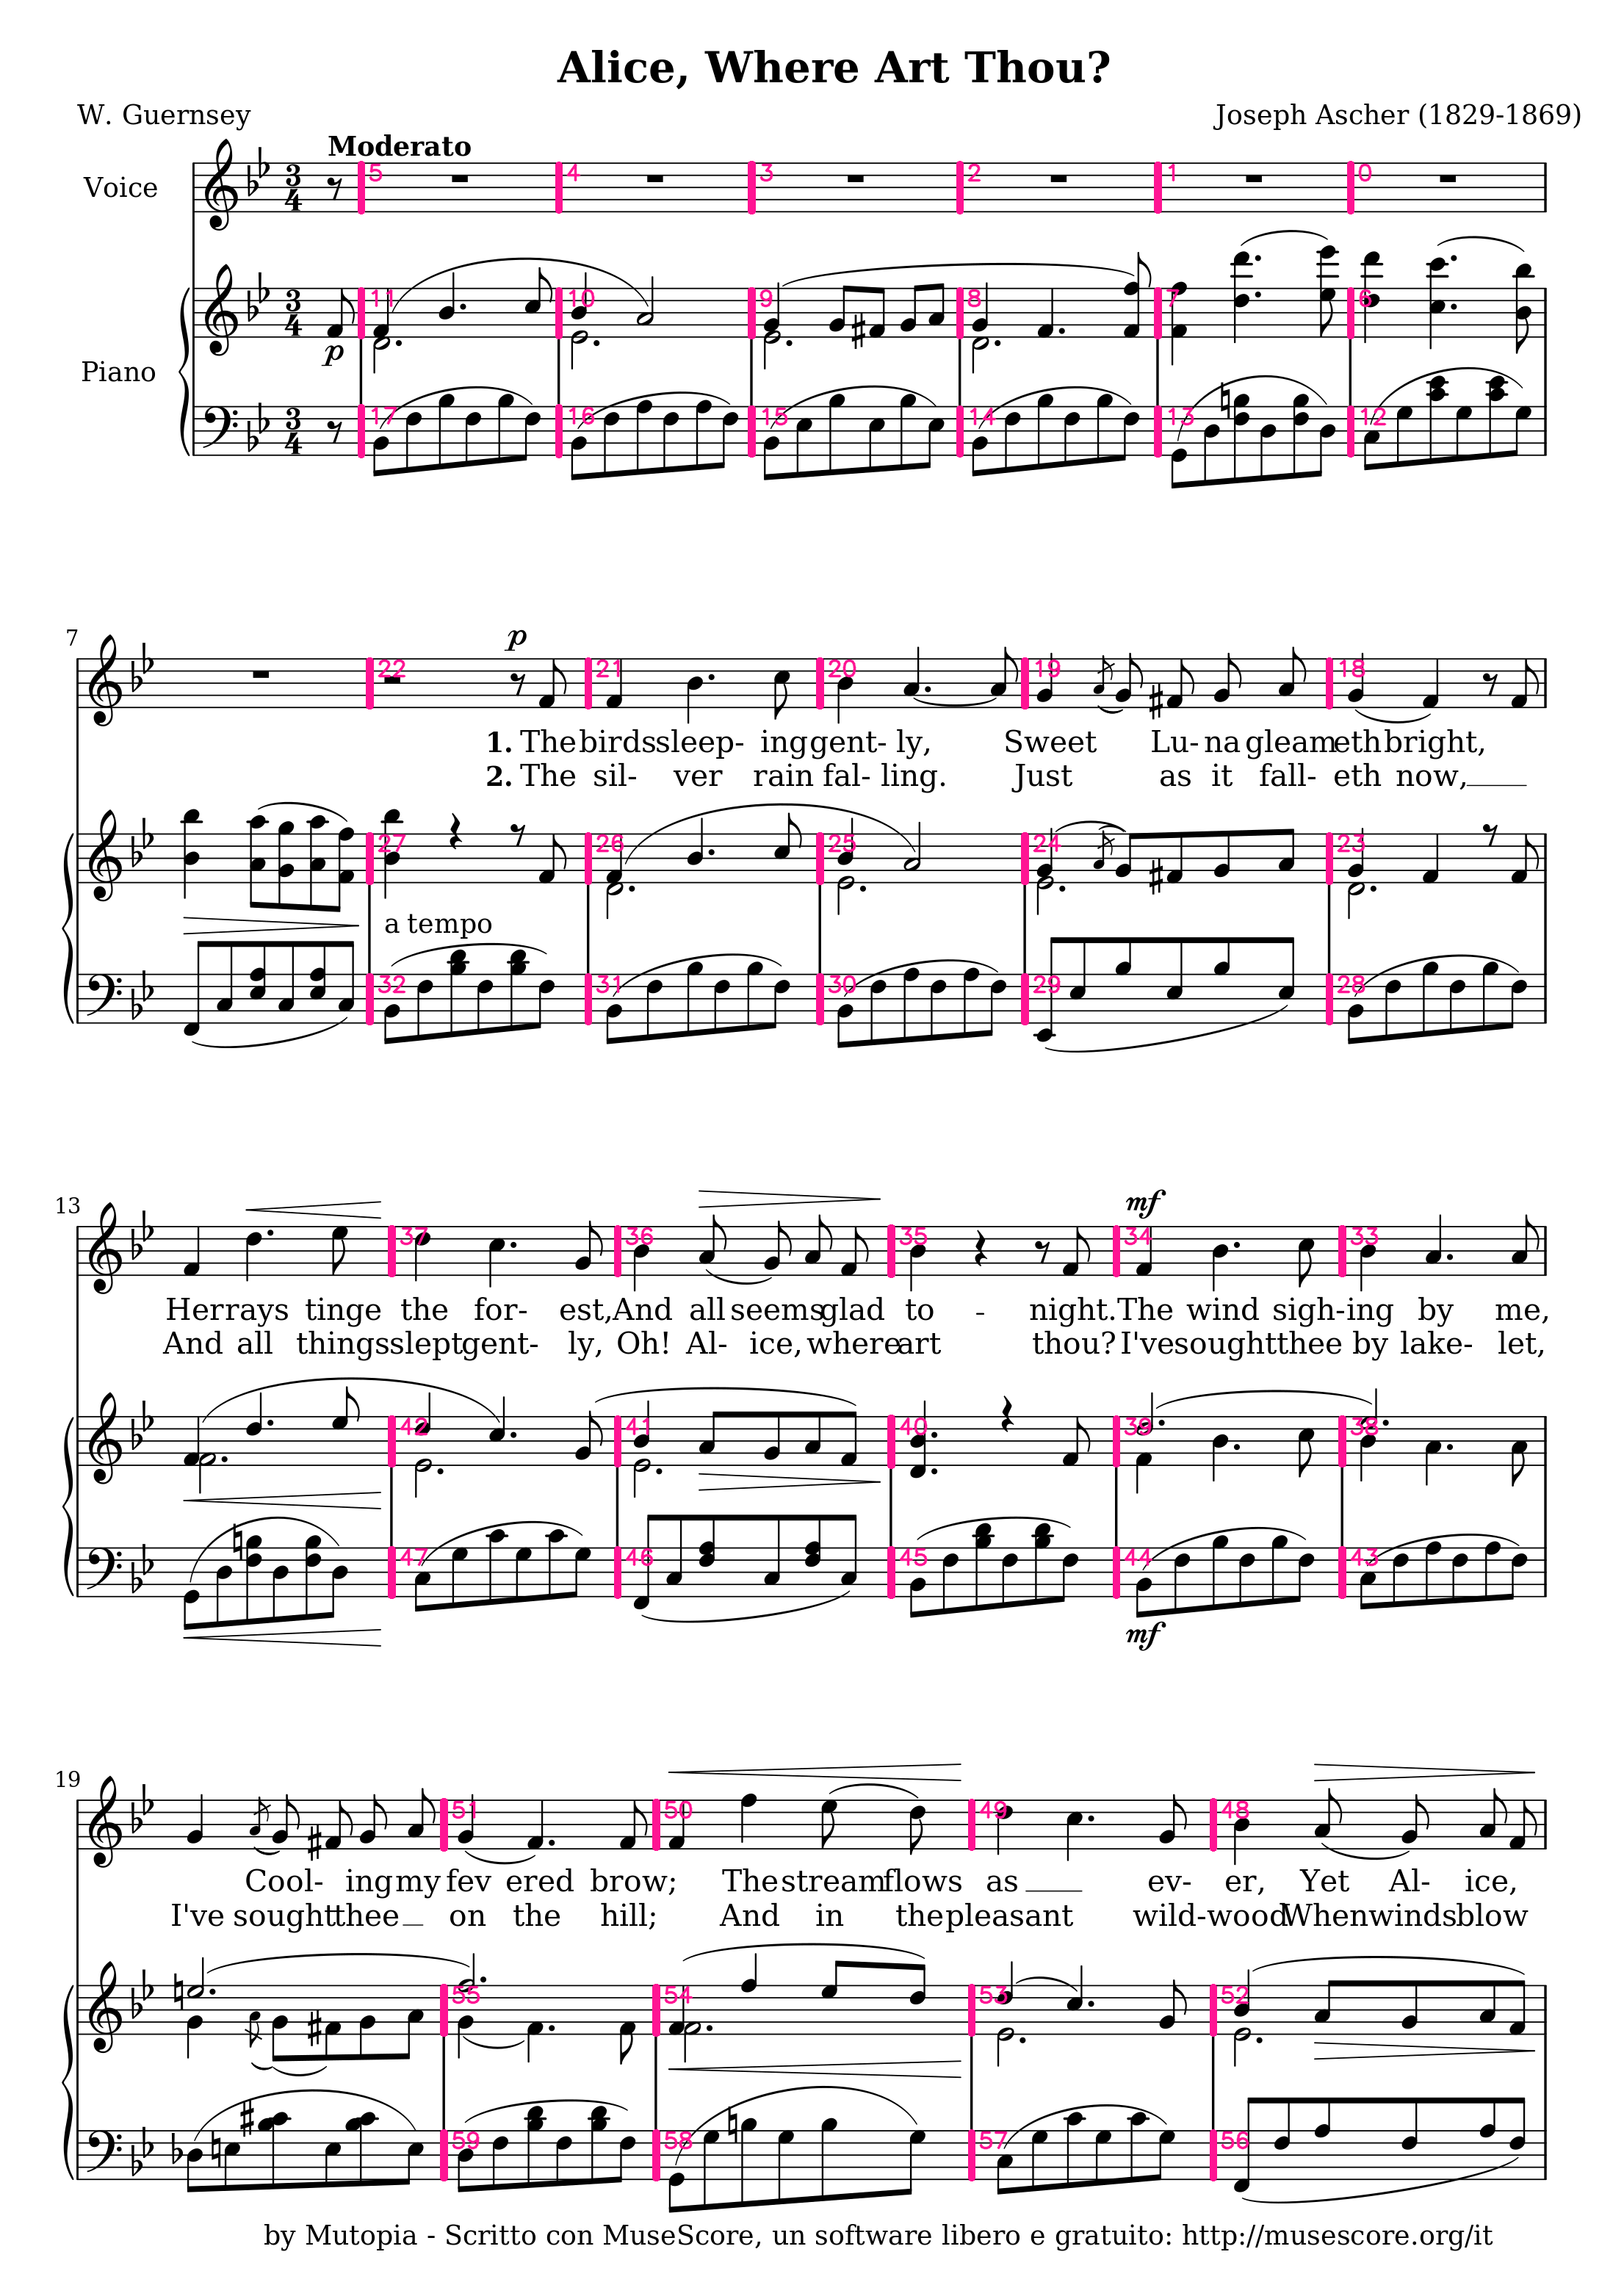

In [352]:
import cv2
import numpy as np
import pandas as pd
from IPython.display import Image

def draw_rectangles(image_path, data):
    image = cv2.imread(image_path)

    if image is None:
        raise ValueError("Image not found or path is incorrect")

    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 1  # Larger text
    font_color = (147, 20, 255)  # Pink
    font_thickness = 2  # Thicker text

    for index, row in data.iterrows():
        points = np.array(row['o_bbox'], dtype=np.int32).reshape((-1, 1, 2))
        # Draw the polygon
        cv2.polylines(image, [points], isClosed=True, color=(147, 20, 255), thickness=5)
        
        # Calculate the position for text (putting it at the center of the polygon)
        M = cv2.moments(points)
        if M["m00"] != 0:
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])
        else:
            # If the contour is too small or has some issues, we'll just use the first point
            cX, cY = points[0][0]

        # Offset the text position above and to the right of the center of the polygon
        text_offset_x = 10  # Horizontal offset
        text_offset_y = -10  # Vertical offset

        # Draw the index number
        cv2.putText(image, str(index), (cX + text_offset_x, cY + text_offset_y), 
                    font, font_scale, font_color, font_thickness, lineType=cv2.LINE_AA)

    return image


result_image = draw_rectangles(f'''./ds2_dense/images/train/{image_path}''', test_df)

# After you have your result_image
cv2.imwrite('./result_image.png', result_image)  # Save the image to a file

# Use IPython display to show the image in the notebook
display(Image(filename='./result_image.png'))

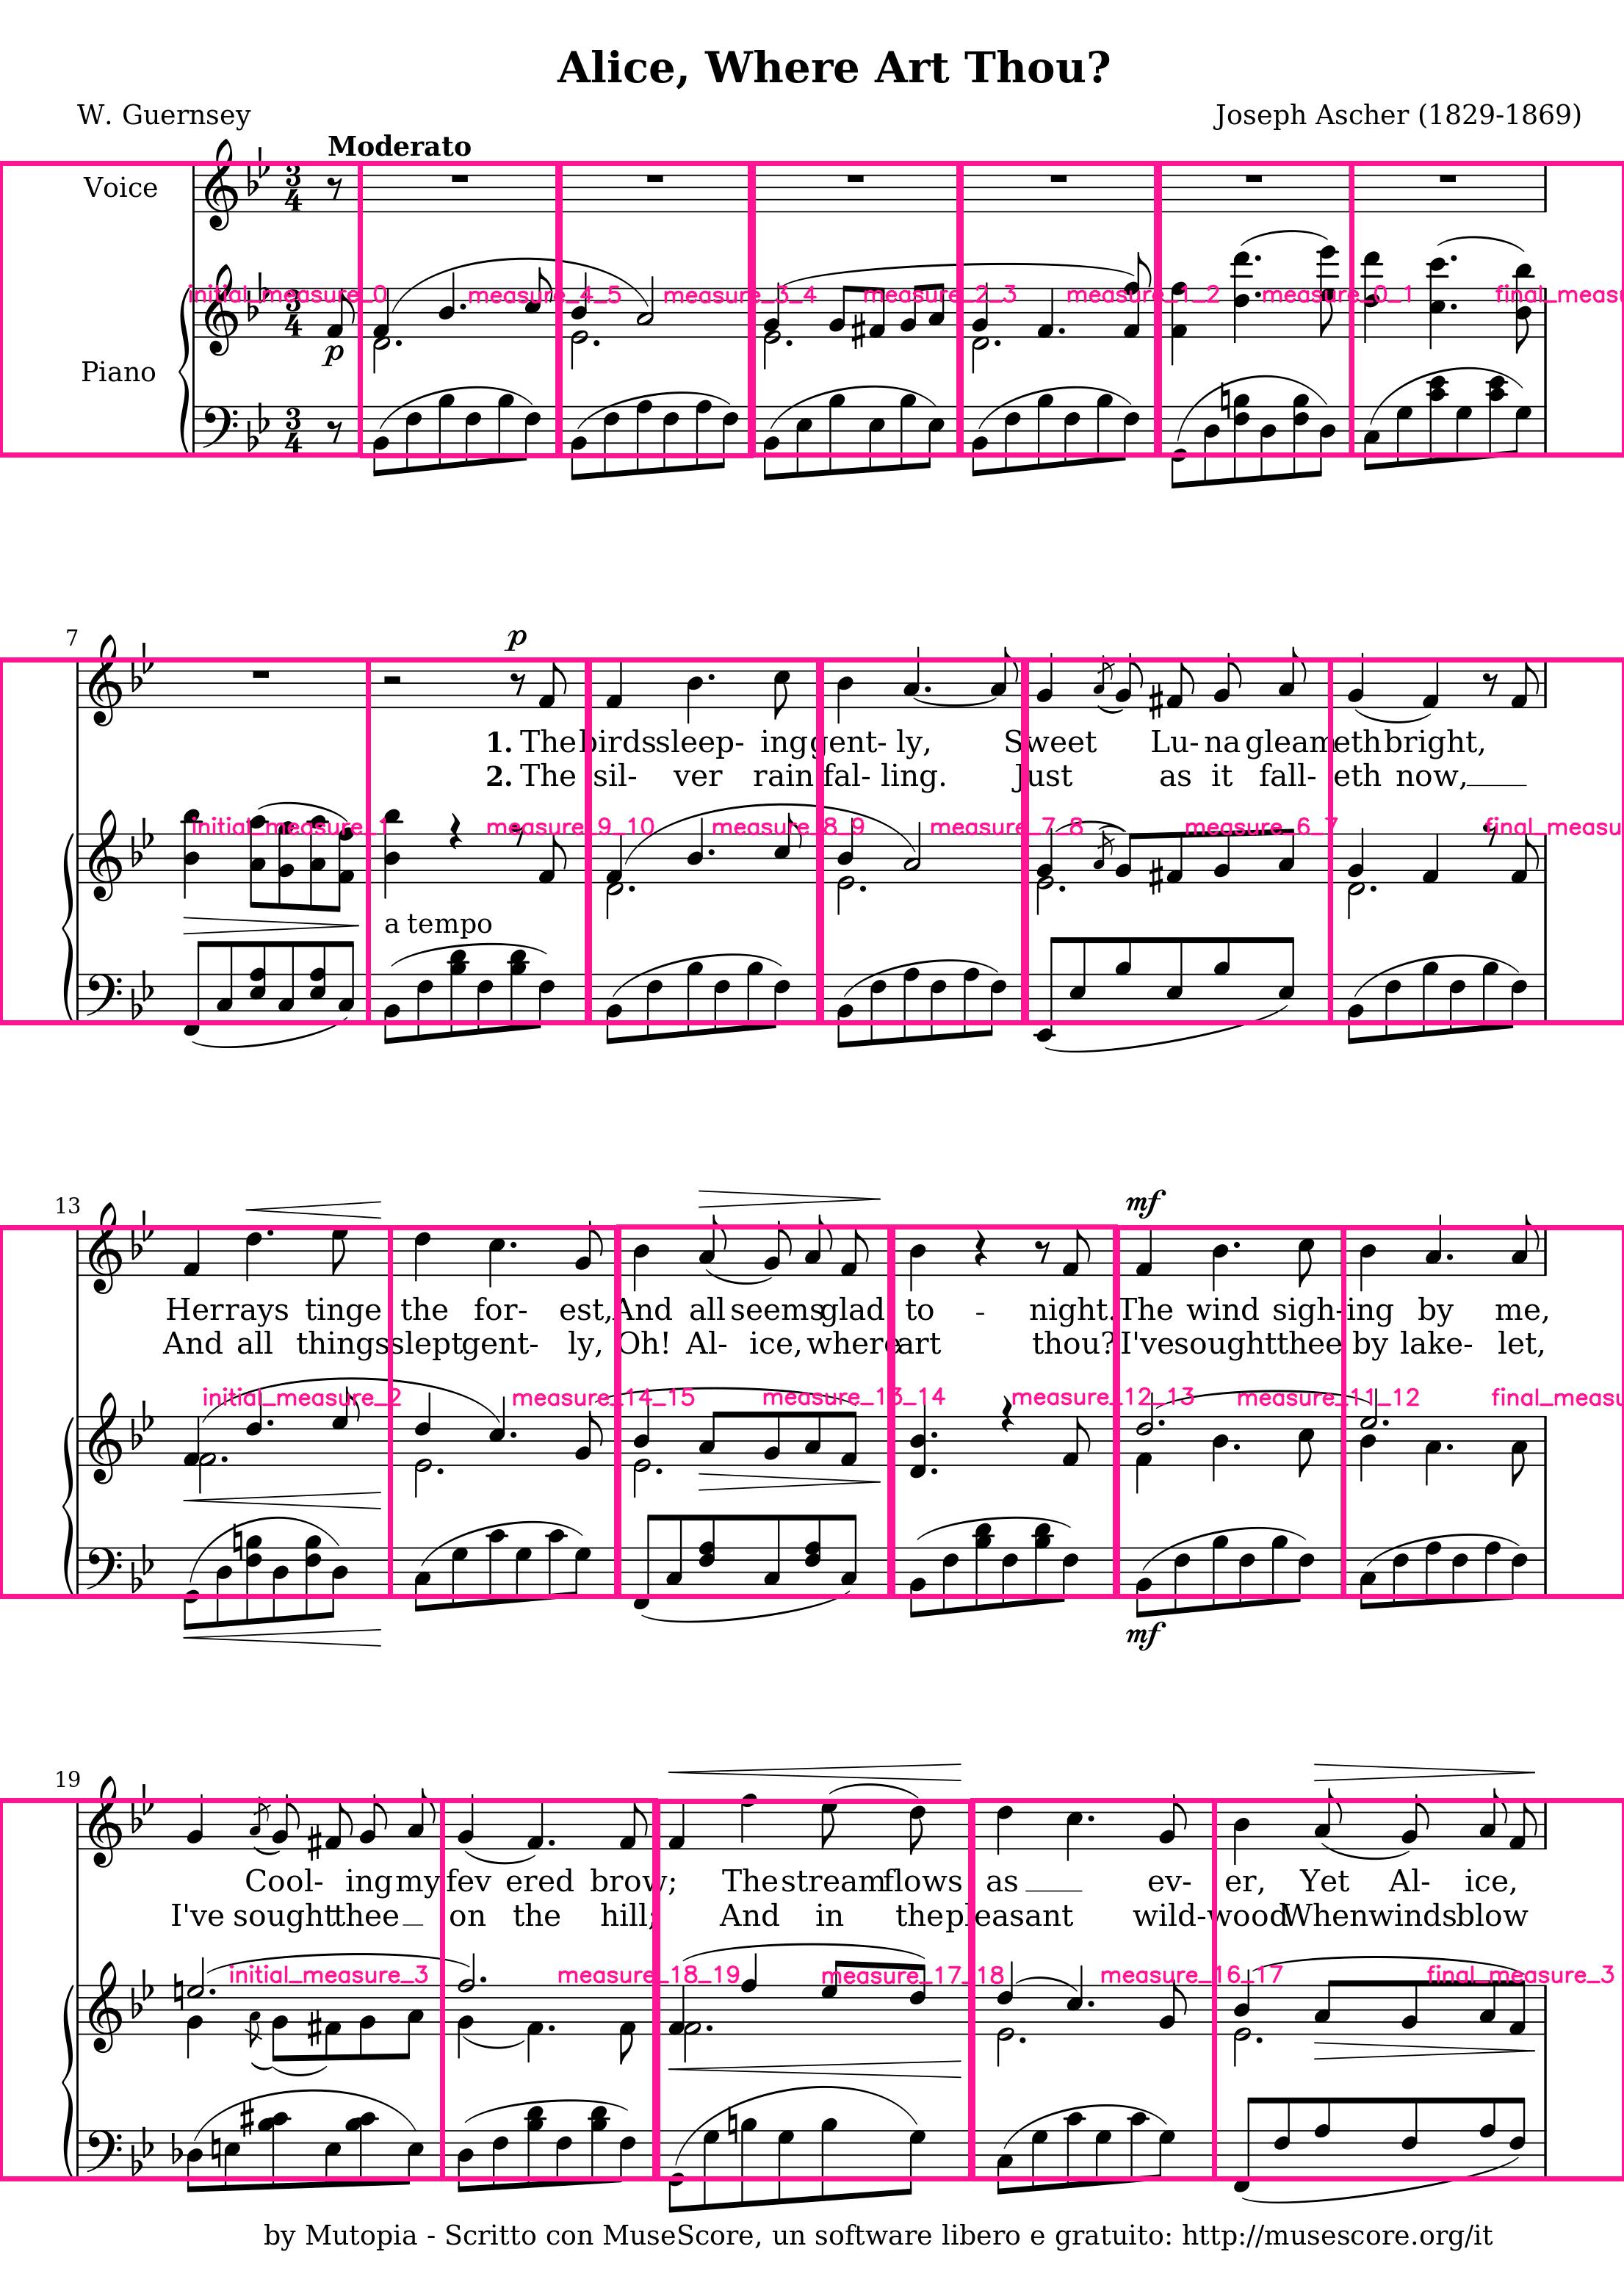

In [353]:
def draw_rectangles(image_path, data):
    image = cv2.imread(image_path)

    if image is None:
        raise ValueError("Image not found or path is incorrect")

    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 1  # Larger text
    font_color = (147, 20, 255)  # Pink
    font_thickness = 2  # Thicker text

    for key, coordinates in data.items():
        points = np.array(coordinates, dtype=np.int32).reshape((-1, 1, 2))
        # Draw the polygon
        cv2.polylines(image, [points], isClosed=True, color=(147, 20, 255), thickness=5)
        
        # if key.startswith('initial_measure'):
        #     print(key, coordinates)

        # Calculate the position for text (putting it at the center of the box)
        M = cv2.moments(points)
        if M["m00"] != 0:
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])
        else:
            # If the contour is too small or has some issues, we'll just use the first point
            cX, cY = points[0][0]

        # Offset the text position above and to the right of the center of the box
        text_offset_x = 10  # Horizontal offset
        text_offset_y = -10  # Vertical offset

        # Draw the index number
        cv2.putText(image, str(key), (cX + text_offset_x, cY + text_offset_y), 
                    font, font_scale, font_color, font_thickness, lineType=cv2.LINE_AA)

    return image

# Filtering
test_df = grouped_bbox_df[grouped_bbox_df["filename"]==image_path]['new_measure_bbox_updated'].values[0]

result_image = draw_rectangles(f'''./ds2_dense/images/train/{image_path}''', test_df)

# After you have your result_image
cv2.imwrite('./result_image.png', result_image)  # Save the image to a file

# Use IPython display to show the image in the notebook
display(Image(filename='./result_image.png'))

#  Script version

In [355]:
def convert_str_to_list(coord_str):
    return ast.literal_eval(coord_str)


# Function to detect if bboxes are on the same line
def on_same_line(bbox1, bbox2):
    # Extract the y-coordinates of the top left corner of the bounding boxes
    y1_top_left = bbox1[1]
    y2_top_left = bbox2[1]
    
    # Check if the y-coordinates are within a 1-2 pixel range
    return abs(y1_top_left - y2_top_left) <= 2

def check_and_assign_measure(group, current_index, measure_num):
    # Check for adjacent line measures and assign the same measure number
    for j in range(current_index + 1, len(group)):
        if group.iat[j, group.columns.get_loc('measure_number')] == -1:
            if abs(group.iat[current_index, group.columns.get_loc('x_coord')] - group.iat[j, group.columns.get_loc('x_coord')]) <= 2 and \
               abs(group.iat[current_index, group.columns.get_loc('line_number')] - group.iat[j, group.columns.get_loc('line_number')]) == 1:
                group.iat[j, group.columns.get_loc('measure_number')] = measure_num
                # Recursively check the next line
                check_and_assign_measure(group, j, measure_num)

def group_measures_by_line(group):
    # Sort the group by line number and measure number
    sorted_group = group.sort_values(by=['line_number', 'measure_number'])
    measure_memo = set()
    # Dictionary to hold the bounding boxes grouped by line and measure
    bbox_groups = {}
    special_measure_count = 1  # Counter for special measures

    # Iterate over each line
    for line_number in sorted_group['line_number'].unique():
        line_data = sorted_group[sorted_group['line_number'] == line_number].copy()

        # Check if there is only one row in this line
        if len(line_data) == 1:

            current_measure = line_data['measure_number'].values[0]

            if current_measure in measure_memo:
                continue
            else:
                measure_memo.add(current_measure)

            measure_key_initial = f"initial_special_measure_{special_measure_count}"
            
            measure_key_final = f"final_special_measure_{special_measure_count}"

            # Initialize measure key if not present
            if measure_key_initial not in bbox_groups:
                bbox_groups[measure_key_initial] = []

            # Initialize measure key if not present
            if measure_key_final not in bbox_groups:
                bbox_groups[measure_key_final] = []
            
            # Original bbox
            bbox_groups[measure_key_initial].append(line_data['o_bbox'].values[0].copy())

            # Original bbox
            bbox_groups[measure_key_final].append(line_data['o_bbox'].values[0].copy())


            # Append all bounding boxes for the same measure
            for coords in group[group['measure_number']==current_measure]['o_bbox'].values:
                bbox_groups[measure_key_initial].append(coords)
                bbox_groups[measure_key_final].append(coords)

            # Modified bbox with certain indices set to 0
            modified_bbox_initial = line_data['o_bbox'].values[0].copy()
            for index in [0]:
                modified_bbox_initial[index] = 0  # Set specified indices to 0
            bbox_groups[measure_key_initial].append(modified_bbox_initial)

            # Modified bbox with certain indices set to 1960
            modified_bbox_final = line_data['o_bbox'].values[0].copy()
            for index in [0]:
                modified_bbox_final[index] = 1960  # Set specified indices to 1960
            bbox_groups[measure_key_final].append(modified_bbox_final)

            special_measure_count += 1

        else:
            # Iterate through the measures in the line normally
            for i in range(len(line_data) - 1):  # -1 because we look ahead one measure
                current_measure = line_data.iloc[i]
                next_measure = line_data.iloc[i + 1]

                # Check if the next measure number is consecutive
                if current_measure['measure_number'] + 1 == next_measure['measure_number']:
                    # Create the key as 'measure_current_current+1'
                    key = f"measure_{current_measure['measure_number']}_{next_measure['measure_number']}"
                    
                    # If the key doesn't exist, create it and assign an empty list
                    if key not in bbox_groups:
                        bbox_groups[key] = []

                    # Append the current and next bounding boxes to the list under the key
                    bbox_groups[key].append(current_measure['o_bbox'])
                    bbox_groups[key].append(next_measure['o_bbox'])

    return bbox_groups

# Function to numerically encode the bar lines based on their y-coordinates
def process_group(group, filename):
    
    # Sort by y-coordinate first to group by line, then by x-coordinate to maintain left-to-right order
    # Assuming 'o_bbox' is a list with the structure [x1, y1, x2, y2, x3, y3, x4, y4]
    # where (x1, y1) are the coordinates for the top-left corner of the bbox
    group = group.sort_values(by=['o_bbox']).reset_index(drop=True)
    
    # Split the 'o_bbox' column into separate x and y columns for sorting
    group['x_coord'] = group['o_bbox'].apply(lambda x: x[0])  # x1 coordinate
    group['y_coord'] = group['o_bbox'].apply(lambda x: x[1])  # y1 coordinate
    group = group.sort_values(by=['y_coord', 'x_coord']).reset_index(drop=True)

    # Initialize line number
    line_number = 0
    group['line_number'] = line_number  # Initialize line number column
    
    # Iterate through each bbox
    for i in range(1, len(group)):
        # If the y-coordinates change significantly, it's a new line
        if not on_same_line(group.iloc[i-1]['o_bbox'], group.iloc[i]['o_bbox']):
            line_number += 1
            # probably error
            if line_number == 100:
                print(f"Line number exceeded 100 for {filename}")
        # Assign the current line number
        group.iat[i, group.columns.get_loc('line_number')] = line_number

    # Normalize the y-coordinates within each line
    for line in group['line_number'].unique():
        mean_y = group[group['line_number'] == line]['y_coord'].mean()
        group.loc[group['line_number'] == line, 'y_coord'] = mean_y

    # Identify and remove redundant barlines
    max_x_per_line = group.groupby('line_number')['x_coord'].max()
    group = group[group.apply(lambda row: row['x_coord'] < max_x_per_line[row['line_number']], axis=1)]

    # Initialize measure numbers
    group['measure_number'] = -1  # Initialize with -1 to denote unassigned measures
    measure_number = 0

    group = group.sort_values(by=['y_coord', 'x_coord'], ascending=[True, False]).reset_index(drop=True)

    # Assign measure numbers by comparing each bbox to every other bbox
    for i in range(len(group)):
        if group.iat[i, group.columns.get_loc('measure_number')] == -1:
            group.iat[i, group.columns.get_loc('measure_number')] = measure_number
            check_and_assign_measure(group, i, measure_number)
            measure_number += 1  # Increment measure number after fully exploring all consecutive lines

        if measure_number == 200:
            print(f"Measure number exceeded 200 for {filename}")  # Error handling if too many measures


    # Drop the helper columns after processing
    group.drop(['x_coord', 'y_coord'], axis=1, inplace=True)
    
    return group

def process_bboxes_initial(data, tolerance=2):
    # Group by min_y and max_y and find the minimum min_x for each group, within a tolerance
    grouped_data = {}
    new_bboxes = {}  # Use this to store new entries

    for key, box in data.items():
        if key.startswith('measure'):
            min_x, min_y, max_x, max_y = box[0], box[1], box[2], box[5]

            # Check if min_x is within the tolerance to continue processing
            if min_x < tolerance:
                continue  # Skip this entry if it doesn't meet criteria

            similar_y_key_found = False
            # Check each y_key in grouped_data to see if it's within the tolerance level
            for y_key in grouped_data.keys():
                if (abs(y_key[0] - min_y) <= tolerance) and (abs(y_key[1] - max_y) <= tolerance):
                    # If found, update the similar y_key with the min of min_x values
                    grouped_data[y_key] = min(grouped_data[y_key], min_x)
                    similar_y_key_found = True
                    break

            # If no similar y_key was found, add this box as a new entry
            if not similar_y_key_found:
                grouped_data[(min_y, max_y)] = min_x

    # Create new bounding boxes using the real min_x and the y_key values
    count = 0
    for y_key, real_min_x in grouped_data.items():
        if real_min_x == 0:
            continue  # Skip entries with real_min_x set to zero
        new_key = f"initial_measure_{count}"
        new_bboxes[new_key] = [0, y_key[0], real_min_x, y_key[0], real_min_x, y_key[1], 0, y_key[1]]
        count += 1

    # Update the original data dictionary with new entries
    data.update(new_bboxes)

    return data

def process_bboxes_final_new(row, tolerance=2):

    # Extract data from the row
    data = row['new_measure_bbox']
    width = row['width']
    height = row['height']

    # Group by min_y and max_y and find the maximum min_x for each group, within a tolerance
    grouped_data = {}
    new_bboxes = {}

    for key, box in data.items():
        if key.startswith('measure'):
            min_x, min_y, max_x, max_y = box[0], box[1], box[2], box[5]

            # This will be used to check if we have a similar y_key already in grouped_data
            similar_y_key_found = False

            # Check each y_key in grouped_data to see if it's within the tolerance level
            for y_key in grouped_data.keys():
                if (abs(y_key[0] - min_y) <= tolerance) and (abs(y_key[1] - max_y) <= tolerance):
                    # If found, update the similar y_key with the max of max_x values
                    grouped_data[y_key] = max(grouped_data[y_key], max_x)
                    similar_y_key_found = True
                    break

            # If no similar y_key was found, add this box as a new entry
            if not similar_y_key_found:
                grouped_data[(min_y, max_y)] = max_x

    # Form the new bounding boxes using the real max_x and the y_key values
    count = 0
    for y_key, real_max_x in grouped_data.items():
        new_key = f"final_measure_{count}"
        new_bboxes[new_key] = [width, y_key[0], real_max_x, y_key[0], real_max_x, y_key[1], width, y_key[1]]
        count += 1

    # Update the original data dictionary with new entries
    data.update(new_bboxes)

    return data

# Function to process each dictionary and extract min/max coordinates
def calc_coordinates(bbox_dict):
    result = {}
    for key, bboxes in bbox_dict.items():
        min_x = min(min(bbox[0], bbox[2], bbox[4], bbox[6]) for bbox in bboxes)
        min_y = min(min(bbox[1], bbox[3], bbox[5], bbox[7]) for bbox in bboxes)
        max_x = max(max(bbox[0], bbox[2], bbox[4], bbox[6]) for bbox in bboxes)
        max_y = max(max(bbox[1], bbox[3], bbox[5], bbox[7]) for bbox in bboxes)
        result[key] = [min_x, min_y, max_x, min_y, max_x, max_y, min_x, max_y]
    return result

def analyze_image_for_measures(df):

    # df['a_bbox'] = df['a_bbox'].apply(convert_str_to_list)
    # df['o_bbox'] = df['o_bbox'].apply(convert_str_to_list)

    df['a_bbox'] = df['a_bbox'].apply(json.loads)
    df['o_bbox'] = df['o_bbox'].apply(json.loads)

    # Sort by 'filename' first, then by y-coordinate, then by x-coordinate
    df = df.iloc[np.lexsort((df['o_bbox'].apply(lambda x: x[0]),
                                                    df['o_bbox'].apply(lambda x: x[1]),
                                                    df['filename']))]
    
    # get the measure number and line numbers for the bars
    df = df.groupby('filename', group_keys=False).apply(lambda x: process_group(x, x.name), include_groups=True).reset_index(drop=True)
    df = df.sort_values(by=['filename', 'line_number', 'measure_number']) # -

    # Create a new df which includes filename, and coordinates of the measures
    grouped_bbox_data = df.groupby("filename").apply(group_measures_by_line, include_groups=False)
    grouped_bbox_df = pd.DataFrame(grouped_bbox_data).reset_index()

    # Load JSON data into a dictionary
    with open('./deepscores_train.json') as file:
        data1 = json.load(file)

    train_images = pd.DataFrame( data1['images'])

    # Update the width and height of the images
    filename_to_dimensions = dict(zip(train_images['filename'], zip(train_images['width'], train_images['height'])))

    # Use map to update 'width' and 'height' columns in measures_df based on filename
    grouped_bbox_df['width'] = grouped_bbox_df['filename'].map(lambda x: filename_to_dimensions.get(x, (np.nan, np.nan))[0])
    grouped_bbox_df['height'] = grouped_bbox_df['filename'].map(lambda x: filename_to_dimensions.get(x, (np.nan, np.nan))[1])

    # drop the line number, measure number in the expanded df for concatenation
    df.drop(['line_number', 'measure_number'], axis=1, inplace=True) # -

    # Apply the function, 0 is the column which includes the coordinates of the measures as a dictionary
    grouped_bbox_df['measure_bbox'] = grouped_bbox_df[0].apply(calc_coordinates)

    # Apply the function to add the initial measure at each line
    grouped_bbox_df['new_measure_bbox'] = grouped_bbox_df['measure_bbox'].apply(process_bboxes_initial)
    
    # Apply the function to add the final measure at each line
    grouped_bbox_df['new_measure_bbox_updated'] = grouped_bbox_df.apply(process_bboxes_final_new, axis=1)

    # Drop the previously created columns
    grouped_bbox_df.drop([0, 'measure_bbox', 'new_measure_bbox'], axis=1, inplace=True) # -

    # Create a new df using the existing one
    # Create a new DataFrame to hold the expanded data
    expanded_rows = []

    # Iterate over each row in the DataFrame
    for index, row in grouped_bbox_df.iterrows():
        filename = row['filename']
        bbox_dict = row['new_measure_bbox_updated']
        
        # Iterate over each item in the dictionary to create new rows
        for key, value in bbox_dict.items():
            expanded_rows.append({'filename': filename, 'o_bbox': value})

    # Create a new DataFrame from the expanded rows
    expanded_df = pd.DataFrame(expanded_rows)

    # Create 'a_bbox' column by selecting specific indices directly
    expanded_df['a_bbox'] = expanded_df['o_bbox'].apply(lambda x: [x[0], x[1], x[4], x[5]])

    expanded_df['padded_o_bbox'] = expanded_df['o_bbox']
    expanded_df['padded_a_bbox'] = expanded_df['a_bbox']

    expanded_df['area'] = expanded_df['a_bbox'].apply(lambda x: (x[2] - x[0]) * (x[3] - x[1]))
    expanded_df['width'] = expanded_df['a_bbox'].apply(lambda x: (x[2] - x[0]))
    expanded_df['height'] = expanded_df['a_bbox'].apply(lambda x: (x[3] - x[1]))

    expanded_df['label'] = 157
    expanded_df['duration'] = -1
    expanded_df['rel_position'] = 0
    expanded_df['duration_mask'] = 0
    expanded_df['rel_position_mask'] = 0

    # Find the smallest value in the column of the other DataFrame
    min_value = df['ann_id'].min()

    # Calculate the start point for ann_id
    start_point = min_value - 1

    # Create the ann_id column by generating a sequence starting from start_point
    expanded_df['ann_id'] = start_point - expanded_df.index

    # Concatenate the new dataframe with the original after adding the above columns
    concatenated_df = pd.concat([df, expanded_df[df.columns]], ignore_index=True)

    return concatenated_df

barline_annotations = pd.read_csv('deepscores_train_barlines.csv')

testing = analyze_image_for_measures(barline_annotations)

testing.head()

/var/folders/g8/btdyhprd6l7_z7kmyr6qhzp80000gn/T/ipykernel_20357/3568916817.py:271: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('filename', group_keys=False).apply(lambda x: process_group(x, x.name), include_groups=True).reset_index(drop=True)


,filename,a_bbox,o_bbox,padded_a_bbox,padded_o_bbox,area,width,height,ann_id,label,duration,rel_position,duration_mask,rel_position_mask
0,lg-101766503886095953-aug-beethoven--page-1.png,"[1387.0, 377.0, 1390.0, 443.0]","[1387.0, 377.0, 1387.0, 443.0, 1390.0, 443.0, ...","[1387.0, 377.0, 1390.0, 443.0]","[1387.0, 377.0, 1387.0, 443.0, 1390.0, 443.0, ...",198.0,-1.0,-1.0,-5157,156,-1,0,0,0
1,lg-101766503886095953-aug-beethoven--page-1.png,"[910.0, 377.0, 913.0, 443.0]","[910.0, 377.0, 910.0, 443.0, 913.0, 443.0, 913...","[910.0, 377.0, 913.0, 443.0]","[910.0, 377.0, 910.0, 443.0, 913.0, 443.0, 913...",198.0,-1.0,-1.0,-5158,156,-1,0,0,0
2,lg-101766503886095953-aug-beethoven--page-1.png,"[1387.0, 606.0, 1390.0, 671.0]","[1387.0, 606.0, 1387.0, 671.0, 1390.0, 671.0, ...","[1387.0, 606.0, 1390.0, 671.0]","[1387.0, 606.0, 1387.0, 671.0, 1390.0, 671.0, ...",195.0,-1.0,-1.0,-5153,156,-1,0,0,0
3,lg-101766503886095953-aug-beethoven--page-1.png,"[910.0, 606.0, 913.0, 671.0]","[910.0, 606.0, 910.0, 671.0, 913.0, 671.0, 913...","[910.0, 606.0, 913.0, 671.0]","[910.0, 606.0, 910.0, 671.0, 913.0, 671.0, 913...",195.0,-1.0,-1.0,-5154,156,-1,0,0,0
4,lg-101766503886095953-aug-beethoven--page-1.png,"[1387.0, 834.0, 1390.0, 899.0]","[1387.0, 834.0, 1387.0, 899.0, 1390.0, 899.0, ...","[1387.0, 834.0, 1390.0, 899.0]","[1387.0, 834.0, 1387.0, 899.0, 1390.0, 899.0, ...",195.0,-1.0,-1.0,-5150,156,-1,0,0,0
